# ESPnet Speech Enhancement Demonstration

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1fjRJCh96SoYLZPRxsjF9VDv4Q2VoIckI?usp=sharing)


This notebook provides a demonstration of the speech enhancement and separation using ESPnet2-SE.

- ESPnet2-SE: https://github.com/espnet/espnet/tree/master/egs2/TEMPLATE/enh1

Author: Chenda Li ([@LiChenda](https://github.com/LiChenda)), Wangyou Zhang ([@Emrys365](https://github.com/Emrys365))


## Install

In [1]:
%pip install git+https://github.com/espnet/espnet
%pip install -q espnet_model_zoo

  Cloning https://github.com/espnet/espnet to /tmp/pip-req-build-l6g5xnfu
  Running command git clone --filter=blob:none --quiet https://github.com/espnet/espnet /tmp/pip-req-build-l6g5xnfu
  Resolved https://github.com/espnet/espnet to commit 4610653eb0d806715664a314df59992f664d9ef9
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done


## Speech Enhancement

### Single-Channel Enhancement, the CHiME example


In [2]:
# Download one utterance from real noisy speech of CHiME4
!gdown --id 1SmrN5NFSg6JuQSs2sfy3ehD8OIcqK6wS -O /content/M05_440C0213_PED_REAL.wav
import os

import soundfile
from IPython.display import display, Audio
mixwav_mc, sr = soundfile.read("/content/M05_440C0213_PED_REAL.wav")
# mixwav.shape: num_samples, num_channels
mixwav_sc = mixwav_mc[:,4]
display(Audio(mixwav_mc.T, rate=sr))

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1SmrN5NFSg6JuQSs2sfy3ehD8OIcqK6wS
To: /content/M05_440C0213_PED_REAL.wav
100% 932k/932k [00:00<00:00, 8.04MB/s]


#### Download and load the pretrained Conv-Tasnet


In [3]:
# !gdown --id 17DMWdw84wF3fz3t7ia1zssdzhkpVQGZm -O /content/chime_tasnet_singlechannel.zip
# !unzip /content/chime_tasnet_singlechannel.zip -d /content/enh_model_sc
# cfg = {
#     "train_config": "/content/enh_model_sc/exp/enh_train_enh_conv_tasnet_raw/config.yaml",
#     "model_file": "/content/enh_model_sc/exp/enh_train_enh_conv_tasnet_raw/5epoch.pth",
# }

##########################################################
# If the above command failed, try the following instead #
##########################################################
from espnet_model_zoo.downloader import ModelDownloader

d = ModelDownloader()
cfg = d.download_and_unpack("espnet/Wangyou_Zhang_chime4_enh_train_enh_conv_tasnet_raw")

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

In [4]:
# Load the model
# If you encounter error "No module named 'espnet2'", please re-run the 1st Cell. This might be a colab bug.
import sys
import soundfile
from espnet2.bin.enh_inference import SeparateSpeech


separate_speech = {}
# For models downloaded from GoogleDrive, you can use the following script:
enh_model_sc = SeparateSpeech(
  train_config=cfg["train_config"],
  model_file=cfg["model_file"],
  # for segment-wise process on long speech
  normalize_segment_scale=False,
  show_progressbar=True,
  ref_channel=4,
  normalize_output_wav=True,
  device="cuda:0",
)

Exception in thread Thread-13:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 1378, in run
    self.function(*self.args, **self.kwargs)
  File "/usr/local/lib/python3.10/dist-packages/music21/ipython21/__init__.py", line 44, in loadNoMagic
    load_ipython_extension(localIP)
  File "/usr/local/lib/python3.10/dist-packages/music21/ipython21/ipExtension.py", line 32, in load_ipython_extension
    ip.run_line_magic('config', "InlineBackend.figure_format = 'retina'")
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2418, in run_line_magic
    result = fn(*args, **kwargs)
  File "<decorator-gen-41>", line 2, in config
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/magics/config.py", 

#### Enhance the single-channel real noisy speech in CHiME4



In [6]:
# play the enhanced single-channel speech
wave = enh_model_sc(mixwav_sc[None, ...], sr)
print("Input real noisy speech", flush=True)
display(Audio(mixwav_sc, rate=sr))
print("Enhanced speech", flush=True)
display(Audio(wave[0].squeeze(), rate=sr))

Input real noisy speech


Enhanced speech


In [10]:
print(sr)
print(rate)

16000
48000


### Enhance your own pre-recordings


In [11]:
from google.colab import files
from IPython.display import display, Audio
import soundfile

uploaded = files.upload()

for file_name in uploaded.keys():
  speech, rate = soundfile.read(file_name)

  assert rate == sr, "mismatch in sampling rate"
  wave = enh_model_sc(speech[None, ...], sr)
  print(f"Your input speech {file_name}", flush=True)
  display(Audio(speech, rate=sr))
  print(f"Enhanced speech for {file_name}", flush=True)
  display(Audio(wave[0].squeeze(), rate=sr))



Saving test_audio_ds.wav to test_audio_ds.wav
Your input speech test_audio_ds.wav


Enhanced speech for test_audio_ds.wav


### Multi-Channel Enhancement


#### Download and load the pretrained models.



In [12]:
#@title Choose Speech Enhancement model { run: "auto" }

fs = 16000 #@param {type:"integer"}
tag = "espnet/Wangyou_Zhang_chime4_enh_train_enh_beamformer_mvdr_raw" #@param ["espnet/Wangyou_Zhang_chime4_enh_train_enh_beamformer_mvdr_raw", "espnet/Wangyou_Zhang_chime4_enh_train_enh_dc_crn_mapping_snr_raw", "lichenda/chime4_fasnet_dprnn_tac", "https://zenodo.org/record/6025881/files/enh_train_enh_beamformer_mvdr_raw_valid.si_snr.ave.zip"]

In [13]:
# For models uploaded to Zenodo or HuggingFace, you can use the following python script instead:
import sys
import soundfile
from espnet_model_zoo.downloader import ModelDownloader
from espnet2.bin.enh_inference import SeparateSpeech

d = ModelDownloader()

cfg = d.download_and_unpack(tag)
enh_model_mc = SeparateSpeech(
  train_config=cfg["train_config"],
  model_file=cfg["model_file"],
  # for segment-wise process on long speech
  normalize_segment_scale=False,
  show_progressbar=True,
  ref_channel=4,
  normalize_output_wav=True,
  device="cuda:0",
)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

#### Enhance the multi-channel real noisy speech in CHiME4



In [14]:
wave = enh_model_mc(mixwav_mc[None, ...], sr)
print("Input real noisy speech", flush=True)
display(Audio(mixwav_mc.T, rate=sr))
print(f"Enhanced speech with model {tag}", flush=True)
display(Audio(wave[0].squeeze(), rate=sr))

Input real noisy speech


Enhanced speech with model espnet/Wangyou_Zhang_chime4_enh_train_enh_beamformer_mvdr_raw


## Speech Separation


### Model Selection

Please select model shown in [espnet_model_zoo](https://github.com/espnet/espnet_model_zoo/blob/master/espnet_model_zoo/table.csv)

In this demonstration, we will show different speech separation models on wsj0_2mix.


In [15]:
#@title Choose Speech Separation model { run: "auto" }

fs = 8000 #@param {type:"integer"}
tag = "lichenda/wsj0_2mix_skim_noncausal" #@param ["espnet/chenda-li-wsj0_2mix_enh_train_enh_conv_tasnet_raw_valid.si_snr.ave", "espnet/chenda-li-wsj0_2mix_enh_train_enh_rnn_tf_raw_valid.si_snr.ave", "lichenda/Chenda_Li_wsj0_2mix_enh_dprnn_tasnet", "lichenda/wsj0_2mix_skim_noncausal", "espnet/Wangyou_Zhang_wsj0_2mix_enh_dc_crn_mapping_snr_raw"]

In [16]:
# For models uploaded to Zenodo, you can use the following python script instead:
import sys
import soundfile
from espnet_model_zoo.downloader import ModelDownloader
from espnet2.bin.enh_inference import SeparateSpeech

d = ModelDownloader()

cfg = d.download_and_unpack(tag)
separate_speech = SeparateSpeech(
  train_config=cfg["train_config"],
  model_file=cfg["model_file"],
  # for segment-wise process on long speech
  segment_size=2.4,
  hop_size=0.8,
  normalize_segment_scale=False,
  show_progressbar=True,
  ref_channel=None,
  normalize_output_wav=True,
  device="cuda:0",
)

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

(…)71698038076fde147b6300e19/.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

(…)t_noncausal_raw/images/backward_time.png:   0%|          | 0.00/43.9k [00:00<?, ?B/s]

(…)9/exp/enh_stats_8k/train/feats_stats.npz:   0%|          | 0.00/778 [00:00<?, ?B/s]

(…)et_noncausal_raw/images/forward_time.png:   0%|          | 0.00/42.8k [00:00<?, ?B/s]

(…)enh_skim_tasnet_noncausal_raw/RESULTS.md:   0%|          | 0.00/575 [00:00<?, ?B/s]

(…)nh_skim_tasnet_noncausal_raw/config.yaml:   0%|          | 0.00/3.27k [00:00<?, ?B/s]

(…)09cb871698038076fde147b6300e19/README.md:   0%|          | 0.00/6.50k [00:00<?, ?B/s]

(…)sal_raw/images/gpu_max_cached_mem_GB.png:   0%|          | 0.00/32.9k [00:00<?, ?B/s]

(…)kim_tasnet_noncausal_raw/images/loss.png:   0%|          | 0.00/31.1k [00:00<?, ?B/s]

(…)asnet_noncausal_raw/images/iter_time.png:   0%|          | 0.00/44.0k [00:00<?, ?B/s]

(…)noncausal_raw/images/optim_step_time.png:   0%|          | 0.00/39.2k [00:00<?, ?B/s]

(…)net_noncausal_raw/images/si_snr_loss.png:   0%|          | 0.00/32.2k [00:00<?, ?B/s]

(…)snet_noncausal_raw/images/optim0_lr0.png:   0%|          | 0.00/27.3k [00:00<?, ?B/s]

146epoch.pth:   0%|          | 0.00/23.7M [00:00<?, ?B/s]

(…)snet_noncausal_raw/images/train_time.png:   0%|          | 0.00/45.1k [00:00<?, ?B/s]

(…)09cb871698038076fde147b6300e19/meta.yaml:   0%|          | 0.00/285 [00:00<?, ?B/s]

### Separate Speech Mixture


#### Separate the example in wsj0_2mix testing set

In [17]:
!gdown --id 1ZCUkd_Lb7pO2rpPr4FqYdtJBZ7JMiInx -O /content/447c020t_1.2106_422a0112_-1.2106.wav

import os
import soundfile
from IPython.display import display, Audio

mixwav, sr = soundfile.read("447c020t_1.2106_422a0112_-1.2106.wav")
waves_wsj = separate_speech(mixwav[None, ...], fs=sr)

print("Input mixture", flush=True)
display(Audio(mixwav, rate=sr))
print(f"========= Separated speech with model {tag} =========", flush=True)
print("Separated spk1", flush=True)
display(Audio(waves_wsj[0].squeeze(), rate=sr))
print("Separated spk2", flush=True)
display(Audio(waves_wsj[1].squeeze(), rate=sr))

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ZCUkd_Lb7pO2rpPr4FqYdtJBZ7JMiInx
To: /content/447c020t_1.2106_422a0112_-1.2106.wav
100% 184k/184k [00:00<00:00, 3.28MB/s]


100%|██████████| 13/13 [00:02<00:00,  4.95it/s]

Input mixture


========= Separated speech with model lichenda/wsj0_2mix_skim_noncausal =========
Separated spk1


Separated spk2


In [19]:
print(sr)

8000


#### Separate your own recordings

In [21]:
from google.colab import files
from IPython.display import display, Audio
import soundfile

uploaded = files.upload()

for file_name in uploaded.keys():
  mixwav_yours, rate = soundfile.read(file_name)
  assert rate == sr, "mismatch in sampling rate"
  waves_yours = separate_speech(mixwav_yours[None, ...], fs=sr)
  print("Input mixture", flush=True)
  display(Audio(mixwav_yours, rate=sr))
  print(f"========= Separated speech with model {tag} =========", flush=True)
  print("Separated spk1", flush=True)
  display(Audio(waves_yours[0].squeeze(), rate=sr))
  print("Separated spk2", flush=True)
  display(Audio(waves_yours[1].squeeze(), rate=sr))

Saving test_audio3_ds.wav to test_audio3_ds.wav


100%|██████████| 11/11 [00:01<00:00, 10.03it/s]

Input mixture


========= Separated speech with model lichenda/wsj0_2mix_skim_noncausal =========
Separated spk1


Separated spk2


#### Show spectrums of separated speech

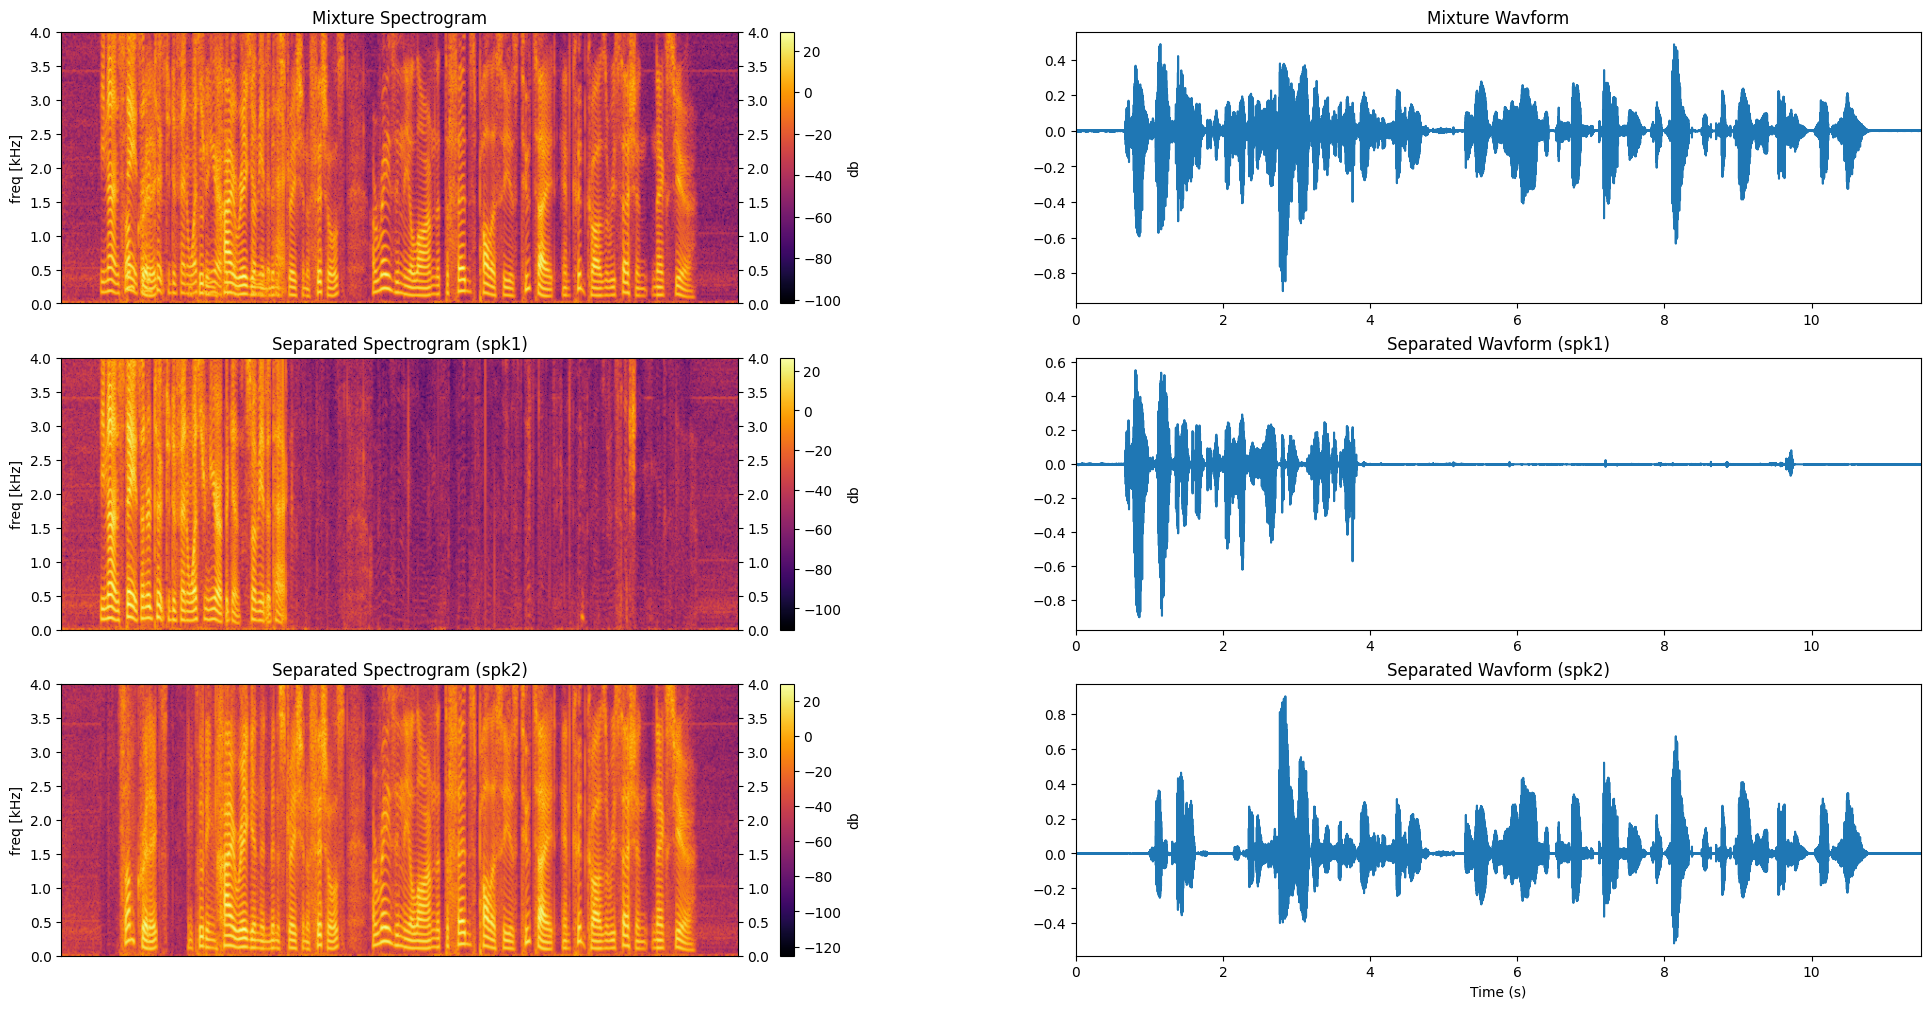

In [22]:
import matplotlib.pyplot as plt
import torch
from torch_complex.tensor import ComplexTensor

from espnet.asr.asr_utils import plot_spectrogram
from espnet2.layers.stft import Stft


stft = Stft(
  n_fft=512,
  win_length=None,
  hop_length=128,
  window="hann",
)
ilens = torch.LongTensor([len(mixwav)])
# specs: (T, F)
spec_mix = ComplexTensor(
    *torch.unbind(
      stft(torch.as_tensor(mixwav).unsqueeze(0), ilens)[0].squeeze(),
      dim=-1
  )
)
spec_sep1 = ComplexTensor(
    *torch.unbind(
      stft(torch.as_tensor(waves_wsj[0]), ilens)[0].squeeze(),
      dim=-1
  )
)
spec_sep2 = ComplexTensor(
    *torch.unbind(
      stft(torch.as_tensor(waves_wsj[1]), ilens)[0].squeeze(),
      dim=-1
  )
)

# freqs = torch.linspace(0, sr / 2, spec_mix.shape[1])
# frames = torch.linspace(0, len(mixwav) / sr, spec_mix.shape[0])
samples = torch.linspace(0, len(mixwav) / sr, len(mixwav))
plt.figure(figsize=(24, 12))
plt.subplot(3, 2, 1)
plt.title('Mixture Spectrogram')
plot_spectrogram(
  plt, abs(spec_mix).transpose(-1, -2).numpy(), fs=sr,
  mode='db', frame_shift=None,
  bottom=False, labelbottom=False
)
plt.subplot(3, 2, 2)
plt.title('Mixture Wavform')
plt.plot(samples, mixwav)
plt.xlim(0, len(mixwav) / sr)

plt.subplot(3, 2, 3)
plt.title('Separated Spectrogram (spk1)')
plot_spectrogram(
  plt, abs(spec_sep1).transpose(-1, -2).numpy(), fs=sr,
  mode='db', frame_shift=None,
  bottom=False, labelbottom=False
)
plt.subplot(3, 2, 4)
plt.title('Separated Wavform (spk1)')
plt.plot(samples, waves_wsj[0].squeeze())
plt.xlim(0, len(mixwav) / sr)

plt.subplot(3, 2, 5)
plt.title('Separated Spectrogram (spk2)')
plot_spectrogram(
  plt, abs(spec_sep2).transpose(-1, -2).numpy(), fs=sr,
  mode='db', frame_shift=None,
  bottom=False, labelbottom=False
)
plt.subplot(3, 2, 6)
plt.title('Separated Wavform (spk2)')
plt.plot(samples, waves_wsj[1].squeeze())
plt.xlim(0, len(mixwav) / sr)
plt.xlabel("Time (s)")
plt.show()

## Evluate separated speech with pretrained ASR model

The ground truths are:

`text_1: SOME CRITICS INCLUDING HIGH REAGAN ADMINISTRATION OFFICIALS ARE RAISING THE ALARM THAT THE FED'S POLICY IS TOO TIGHT AND COULD CAUSE A RECESSION NEXT YEAR`

`text_2: THE UNITED STATES UNDERTOOK TO DEFEND WESTERN EUROPE AGAINST SOVIET ATTACK`

(This may take a while for the speech recognition.)

In [23]:
import espnet_model_zoo
from espnet_model_zoo.downloader import ModelDownloader
from espnet2.bin.asr_inference import Speech2Text

wsj_8k_model_tag="lichenda/wsj_asr_train_asr_transformer_raw_char_8k"

d = ModelDownloader()
speech2text = Speech2Text(
  **d.download_and_unpack(wsj_8k_model_tag),
  device="cuda:0",
)



Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

(…)sr_transformer_raw_char_1gpu/config.yaml:   0%|          | 0.00/3.29k [00:00<?, ?B/s]

(…)r_raw_char_1gpu/images/backward_time.png:   0%|          | 0.00/51.8k [00:00<?, ?B/s]

(…)/exp/asr_stats_raw/train/feats_stats.npz:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

(…)transformer_raw_char_1gpu/images/acc.png:   0%|          | 0.00/31.5k [00:00<?, ?B/s]

(…)27bd9c08c4970b2f7201d277e/.gitattributes:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

(…)asr_transformer_raw_char_1gpu/RESULTS.md:   0%|          | 0.00/366 [00:00<?, ?B/s]

(…)transformer_raw_char_1gpu/images/cer.png:   0%|          | 0.00/26.6k [00:00<?, ?B/s]

(…)sformer_raw_char_1gpu/images/cer_ctc.png:   0%|          | 0.00/27.7k [00:00<?, ?B/s]

(…)2460927bd9c08c4970b2f7201d277e/README.md:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

(…)ormer_raw_char_1gpu/images/iter_time.png:   0%|          | 0.00/31.5k [00:00<?, ?B/s]

(…)ransformer_raw_char_1gpu/images/lr_0.png:   0%|          | 0.00/26.4k [00:00<?, ?B/s]

(…)former_raw_char_1gpu/images/loss_ctc.png:   0%|          | 0.00/34.9k [00:00<?, ?B/s]

(…)raw_char_1gpu/images/optim_step_time.png:   0%|          | 0.00/59.3k [00:00<?, ?B/s]

(…)former_raw_char_1gpu/images/loss_att.png:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

(…)ransformer_raw_char_1gpu/images/loss.png:   0%|          | 0.00/33.1k [00:00<?, ?B/s]

(…)er_raw_char_1gpu/images/forward_time.png:   0%|          | 0.00/40.6k [00:00<?, ?B/s]

(…)rmer_raw_char_1gpu/images/train_time.png:   0%|          | 0.00/31.5k [00:00<?, ?B/s]

(…)77e/exp/lm_train_lm_char_sgd/config.yaml:   0%|          | 0.00/2.21k [00:00<?, ?B/s]

(…)exp/lm_train_lm_char_sgd/images/loss.png:   0%|          | 0.00/34.8k [00:00<?, ?B/s]

(…)rain_lm_char_sgd/images/forward_time.png:   0%|          | 0.00/51.2k [00:00<?, ?B/s]

(…)transformer_raw_char_1gpu/images/wer.png:   0%|          | 0.00/27.5k [00:00<?, ?B/s]

(…)ain_lm_char_sgd/images/backward_time.png:   0%|          | 0.00/46.6k [00:00<?, ?B/s]

(…)m_train_lm_char_sgd/images/iter_time.png:   0%|          | 0.00/51.6k [00:00<?, ?B/s]

37epoch.pth:   0%|          | 0.00/27.4M [00:00<?, ?B/s]

valid.acc.ave_10best.pth:   0%|          | 0.00/109M [00:00<?, ?B/s]

(…)n_lm_char_sgd/images/optim_step_time.png:   0%|          | 0.00/40.8k [00:00<?, ?B/s]

(…)2460927bd9c08c4970b2f7201d277e/meta.yaml:   0%|          | 0.00/404 [00:00<?, ?B/s]

(…)exp/lm_train_lm_char_sgd/images/lr_0.png:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

(…)lm_train_lm_char_sgd/perplexity_test/ppl:   0%|          | 0.00/19.0 [00:00<?, ?B/s]

(…)_train_lm_char_sgd/images/train_time.png:   0%|          | 0.00/48.8k [00:00<?, ?B/s]

In [24]:
text_est = [None, None]
text_est[0], *_ = speech2text(waves_wsj[0].squeeze())[0]
text_est[1], *_ = speech2text(waves_wsj[1].squeeze())[0]
text_m, *_ = speech2text(mixwav)[0]
print("Mix Speech to Text: ", text_m)
print("Separated Speech 1 to Text: ", text_est[0])
print("Separated Speech 2 to Text: ", text_est[1])


Mix Speech to Text:  THE UNITED SAINT CREATED IT TO DEFEND WHAT IT IN A HIGH REAGANITE IT HAD RATION OFFICIALS ARE RAISING THE ALARM THAT THE FED'S POLICIES TOO TIGHT AND COULD CAUSE A RECESSION NEXT YEAR
Separated Speech 1 to Text:  THE UNITED STATES UNDERTOOK TO DEFEND WESTERN EUROPE AGAINST SOVIET ATTACK SUCH
Separated Speech 2 to Text:  SOME CRITICS INCLUDING HIGH REAGAN ADMINISTRATION OFFICIALS ARE RAISING THE ALARM THAT THE FED'S POLICY IS TOO TIGHT AND COULD CAUSE A RECESSION NEXT YEAR


In [25]:
import difflib
from itertools import permutations

import editdistance
import numpy as np

colors = dict(
    red=lambda text: f"\033[38;2;255;0;0m{text}\033[0m" if text else "",
    green=lambda text: f"\033[38;2;0;255;0m{text}\033[0m" if text else "",
    yellow=lambda text: f"\033[38;2;225;225;0m{text}\033[0m" if text else "",
    white=lambda text: f"\033[38;2;255;255;255m{text}\033[0m" if text else "",
    black=lambda text: f"\033[38;2;0;0;0m{text}\033[0m" if text else "",
)

def diff_strings(ref, est):
    """Reference: https://stackoverflow.com/a/64404008/7384873"""
    ref_str, est_str, err_str = [], [], []
    matcher = difflib.SequenceMatcher(None, ref, est)
    for opcode, a0, a1, b0, b1 in matcher.get_opcodes():
        if opcode == "equal":
            txt = ref[a0:a1]
            ref_str.append(txt)
            est_str.append(txt)
            err_str.append(" " * (a1 - a0))
        elif opcode == "insert":
            ref_str.append("*" * (b1 - b0))
            est_str.append(colors["green"](est[b0:b1]))
            err_str.append(colors["black"]("I" * (b1 - b0)))
        elif opcode == "delete":
            ref_str.append(ref[a0:a1])
            est_str.append(colors["red"]("*" * (a1 - a0)))
            err_str.append(colors["black"]("D" * (a1 - a0)))
        elif opcode == "replace":
            diff = a1 - a0 - b1 + b0
            if diff >= 0:
                txt_ref = ref[a0:a1]
                txt_est = colors["yellow"](est[b0:b1]) + colors["red"]("*" * diff)
                txt_err = "S" * (b1 - b0) + "D" * diff
            elif diff < 0:
                txt_ref = ref[a0:a1] + "*" * -diff
                txt_est = colors["yellow"](est[b0:b1]) + colors["green"]("*" * -diff)
                txt_err = "S" * (b1 - b0) + "I" * -diff

            ref_str.append(txt_ref)
            est_str.append(txt_est)
            err_str.append(colors["black"](txt_err))
    return "".join(ref_str), "".join(est_str), "".join(err_str)


text_ref = [
  "SOME CRITICS INCLUDING HIGH REAGAN ADMINISTRATION OFFICIALS ARE RAISING THE ALARM THAT THE FED'S POLICY IS TOO TIGHT AND COULD CAUSE A RECESSION NEXT YEAR",
  "THE UNITED STATES UNDERTOOK TO DEFEND WESTERN EUROPE AGAINST SOVIET ATTACK",
]

print("=====================" , flush=True)
perms = list(permutations(range(2)))
string_edit = [
  [
    editdistance.eval(text_ref[m], text_est[n])
    for m, n in enumerate(p)
  ]
  for p in perms
]

dist = [sum(edist) for edist in string_edit]
perm_idx = np.argmin(dist)
perm = perms[perm_idx]

for i, p in enumerate(perm):
  print("\n--------------- Text %d ---------------" % (i + 1), flush=True)
  ref, est, err = diff_strings(text_ref[i], text_est[p])
  print("REF: " + ref + "\n" + "HYP: " + est + "\n" + "ERR: " + err, flush=True)
  print("Edit Distance = {}\n".format(string_edit[perm_idx][i]), flush=True)


--------------- Text 1 ---------------
REF: SOME CRITICS INCLUDING HIGH REAGAN ADMINISTRATION OFFICIALS ARE RAISING THE ALARM THAT THE FED'S POLICY IS TOO TIGHT AND COULD CAUSE A RECESSION NEXT YEAR
HYP: SOME CRITICS INCLUDING HIGH REAGAN ADMINISTRATION OFFICIALS ARE RAISING THE ALARM THAT THE FED'S POLICY IS TOO TIGHT AND COULD CAUSE A RECESSION NEXT YEAR
ERR:                                                                                                                                                           
Edit Distance = 0


--------------- Text 2 ---------------
REF: THE UNITED STATES UNDERTOOK TO DEFEND WESTERN EUROPE AGAINST SOVIET ATTACK*****
HYP: THE UNITED STATES UNDERTOOK TO DEFEND WESTERN EUROPE AGAINST SOVIET ATTACK SUCH
ERR:                                                                           IIIII
Edit Distance = 5

